<a href="https://colab.research.google.com/github/javierorman/recovery_economics/blob/main/recovery_economics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Economic recovery after recessions in post-WW2 United States

**Javier Orman**  
LinkedIn: [https://www.linkedin.com/in/javierorman/](https://www.linkedin.com/in/javierorman/)  
GitHub: [https://github.com/javierorman](https://github.com/javierorman)

Version: 10-21-2020

Throughout history, the economy of the United States has suffered down-turns of different magnitudes, from the stock-market crash of 1929 (followed by the Great Depression) to the deep recession of 2008 and many others in between.

In this notebook, I explore visually the recoveries that took place after these crises were over. In particular, I compare several indicators across the different post-recession periods: GDP, Unemployment, Gini (wealth inequality) and Debt-to-GDP ratio.

<img src="https://i.insider.com/56a8e95a58c32397008b5943" alt="Lehman Brothers" width="600"/>

## Index

[1. GDP change rates](#section_1)

[2. Unemployment](#section_2)

[3. Wealth Inequality](#section_3)

[4. Debt-to-GDP ratio](#section_4)

[5. All indicators](#section_5)


In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

In [143]:
drive_path = 'drive/My Drive/Colab Notebooks/crises_recovery/datasets/'
rel_path = 'datasets/'

PATH = drive_path

<a id=’section_1’></a>

## GDP change rates

We start by importing a dataset containing changes in Gross Domestic Product (GDP). These are seasonally-adjusted annual rates for each quarter.  

This is a good place to start because we're looking at the overall size of the economy. A common standard for defining recessions is *two consecutive quarters of negative GDP growth* as originally proposed by Commissioner of the Bureau of Labor Statistics Julius Shiskin in 1974.

The dataset comes from the [Bureau of Economic Analysis at the US Department of Commerce](https://www.bea.gov/).

In [144]:
df = pd.read_excel('https://apps.bea.gov/national/xls/gdpchg.xlsx', skiprows=7)
df

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,1930.0,-11.9,-8.5,NaN,1947Q2,4.7,-1.0,NaN
1,1931.0,-16.0,-6.4,NaN,1947Q3,6.0,-0.8,NaN
2,1932.0,-23.1,-12.9,NaN,1947Q4,17.3,6.4,NaN
3,1933.0,-4.0,-1.2,NaN,1948Q1,9.6,6.2,NaN
4,1934.0,16.9,10.8,NaN,1948Q2,10.7,6.8,NaN
...,...,...,...,...,...,...,...,...
288,NaN,NaN,NaN,NaN,2019Q2,4.1,1.5,NaN
289,NaN,NaN,NaN,NaN,2019Q3,4.0,2.6,NaN
290,NaN,NaN,NaN,NaN,2019Q4,3.9,2.4,NaN
291,NaN,NaN,NaN,NaN,2020Q1,-3.4,-5.0,NaN


In [145]:
# The dataset contains yearly data up to 1946 and quarterly data from 1947 onwards. 
# Here we will work with the latter.
df = df.iloc[:, [4, 6]]

In [146]:
# Rename columns
mapper = {'Unnamed: 4': 'period', 'Unnamed: 6': 'gdp_change'}
df.rename(columns=mapper, inplace=True)
df.head()

,period,gdp_change
0,1947Q2,-1.0
1,1947Q3,-0.8
2,1947Q4,6.4
3,1948Q1,6.2
4,1948Q2,6.8


In [147]:
df.dtypes

period         object
gdp_change    float64
dtype: object

In [148]:
# Convert 'period' column to a pandas PeriodIndex type with quarterly frequency
df['period'] = pd.PeriodIndex(df['period'], freq='Q')

In [149]:
# Check column data types and number of missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype        
---  ------      --------------  -----        
 0   period      293 non-null    period[Q-DEC]
 1   gdp_change  293 non-null    float64      
dtypes: float64(1), period[Q-DEC](1)
memory usage: 4.7 KB


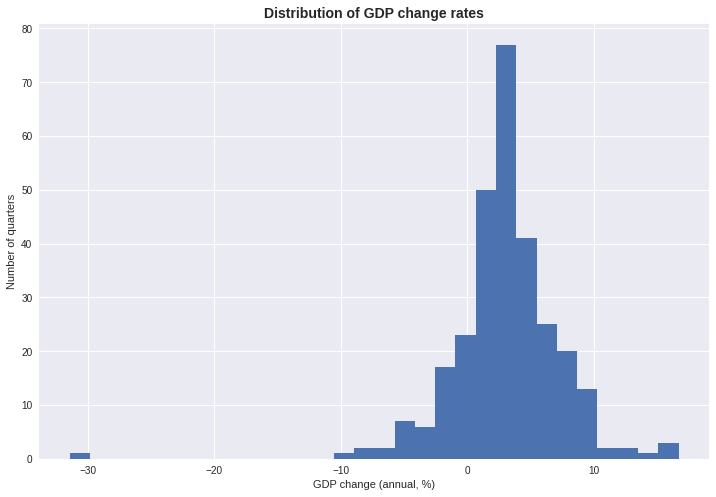

In [150]:
# Histogram of GDP change rates.
df.hist('gdp_change', bins=30, grid=True, figsize=(12, 8))
plt.xlabel('GDP change (annual, %)')
plt.ylabel('Number of quarters')

title_fontdict = {'fontsize': 14, 'fontweight': 'bold'}
plt.title('Distribution of GDP change rates', 
          fontdict=title_fontdict);

In [151]:
bin_width = (df['gdp_change'].max() - df['gdp_change'].min())/30
print(f'Each bin represents a range of %{bin_width} of GDP change rates')

Each bin represents a range of %1.603333333333333 of GDP change rates


The distribution above makes sense, since the the conomy of the United States has, for the most part, grown at a steady pace between 1-5%. The left tail indicates the exceptional quarters during economic downturns.

In [152]:
df.describe()

,gdp_change
count,293.000000
mean,3.061775
std,4.348497
min,-31.400000
25%,1.200000
50%,3.000000
75%,5.100000
max,16.700000


As we observed in the histogram and is confirmed here, the values are centered around 3%. In fact, half of all GDP change values fall between 1.2% and 5.1%.
The minimum (-31.4%) and maximum (16.7%) values are surprisingly extreme. Let's take a quick look at them.

In [153]:
df.loc[(df['gdp_change'] == -31.4) | (df['gdp_change'] == 16.7)]

,period,gdp_change
11,1950Q1,16.7
292,2020Q2,-31.4


The shrinkage of -31.4% corresponds to the economic shutdown during the 2020 COVID-19 pandemic. At the time of this writing, we're not out of the woods, yet, so we'll leave this one for future analyses.

Let's visualize the GDP changes for the whole dataset. But first, let's find all the recession periods so we can visualize them as well.

In [154]:
# Find and store indices for all quarters with negative GDP change
neg_quarters = [i for i in range(len(df)) if df.iloc[i]['gdp_change'] < 0]

# Create a list of dictionaries with 'begin' and 'end' indices for each recession
rec_periods = []
period = {}
for i in neg_quarters:
  if i-1 not in neg_quarters:
    period['begin'] = i
  elif i+1 not in neg_quarters:
    period['end'] = i
    rec_periods.append(period)
    period = {}

In [155]:
rec_periods

[{'begin': 0, 'end': 1},
 {'begin': 7, 'end': 8},
 {'begin': 25, 'end': 27},
 {'begin': 42, 'end': 43},
 {'begin': 90, 'end': 91},
 {'begin': 109, 'end': 111},
 {'begin': 132, 'end': 133},
 {'begin': 138, 'end': 139},
 {'begin': 174, 'end': 175},
 {'begin': 245, 'end': 248},
 {'begin': 291, 'end': 292}]

In [156]:
# Create a function to draw recession stripes. This will come in handy!
def draw_stripes(ax):
  """
  Function to draw stripes representing recessions over an existing axis, 
  with time on the x-axis.
  """
  for period in rec_periods:
    if period['end'] + 1 in df.index:
      ax.axvspan(xmin=df.iloc[period['begin']]['period'], 
                xmax=df.iloc[period['end'] + 1]['period'], 
                alpha=0.2)
    else:
      ax.axvspan(xmin=df.iloc[period['begin']]['period'], 
                xmax=df['period'].max(), 
                alpha=0.2)

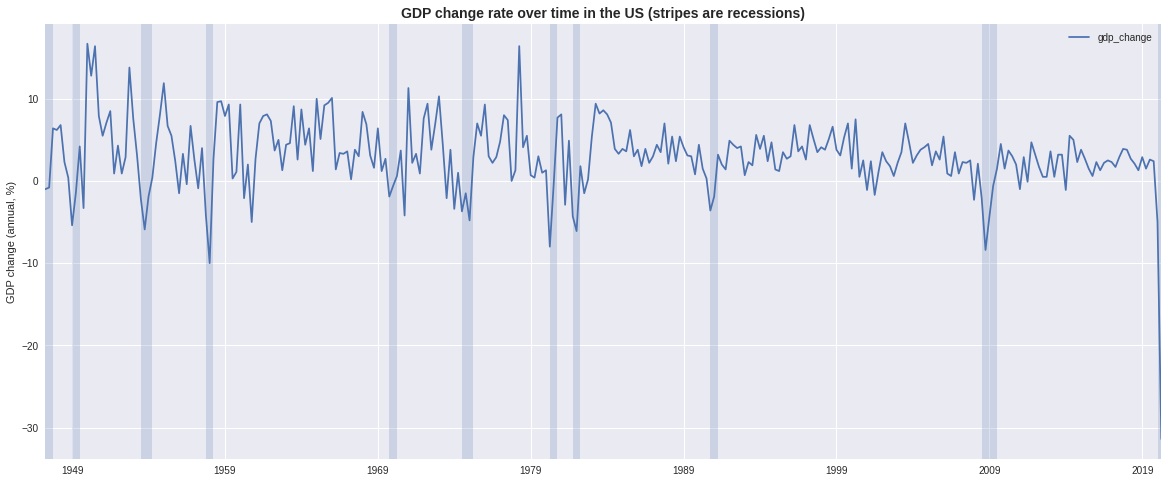

In [157]:
ax = df.plot(x='period', y='gdp_change', figsize=(20,8), grid=True)
plt.xlabel('')
plt.ylabel('GDP change (annual, %)')
plt.title('GDP change rate over time in the US (stripes are recessions)', fontdict=title_fontdict)
draw_stripes(ax=ax)
plt.show()

Next, we find the last quarter of each recession:

In [158]:
rec_ends = [period['end'] for period in rec_periods]

In [159]:
df.iloc[rec_ends]

,period,gdp_change
1,1947Q3,-0.8
8,1949Q2,-1.4
27,1954Q1,-1.9
43,1958Q1,-10.0
91,1970Q1,-0.6
111,1975Q1,-4.8
133,1980Q3,-0.5
139,1982Q1,-6.1
175,1991Q1,-1.9
248,2009Q2,-0.6


In [160]:
# Since we want to look at 'full' recoveries, let's discard instances 
#   where the economic entered a recession soon after:
rec_ends.remove(1)
rec_ends.remove(133)

# At the time of this notebook, the 2020 crisis is ongoing
rec_ends.remove(292)

We have 8 post-recession recoveries that we will look at. Here are the last quarters for each of those recessions:

In [161]:
print(list(df.iloc[rec_ends]['period'].astype('str')))

['1949Q2', '1954Q1', '1958Q1', '1970Q1', '1975Q1', '1982Q1', '1991Q1', '2009Q2']


Because we will visualize several variables (GDP, unemployment, etc.) across many post-recession periods, we should create a function to make this process easy and adaptable.

In [162]:
# But first, we create a function to make a list of indices to pass 
#  to the plot_multiple function that we'll define next. 
def make_idx_list(original_list, column):
  """
  Create a list of indices based on an original list, 
  such that the corresponding rows in the dataframe don't contain empty values 
  or NaNs in the passed column.
  """
  idx = [x for x in original_list if not np.isnan(df.iloc[x][column])]
  return idx

In [163]:
from IPython.display import Javascript
import matplotlib.cm as cm

def plot_multiple(title, column, ylabel, dataframe=df, idx=rec_ends, 
                  num_axes=8, figsize=(12,48), style='o-', yticks=True,
                  legend=False):
  """
  Create multiple plots of a DataFrame's column against the DataFrame's time index
  
  Parameters:
    title : str
      Title to pass to fig.suptitle
    column : str
      Name of column to plot against time index
    ylabel : str
      Label to pass to ax.set_ylabel for each subplot
    dataframe : pd.DataFrame
      DataFrame to use for plotting
    idx : list
      List of indices to be used for each subplot. For each index i, 
      the time series on the horizontal axis will range from i-1 to i+16. 
      For quarters, each subplot will cover from the quarter before i 
      to 16 quarters (4 years) after.
    num_axes : int
      Number of subplots to be created with plt.subplots
    figsize : tuple
      Figure dimensions to be passed to plt.subplots
    style : str
      Line style (for example '-') to be passed to pandas df.plot() 
    yticks: bool
      Whether to use y-ticks or not
    legend: bool
  """
  # Show full cell output without scrolling
  display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

  # Create figure, subplots and set figure title
  fig, axs = plt.subplots(num_axes, 1, figsize=figsize, constrained_layout=True)
  fig.suptitle(title, size=14, weight='bold')

  for i, ax in zip(idx, axs):
    # Compute dataframe for each time period
    df_rec = dataframe.iloc[i-1:i+16]

    # Draw plot
    df_rec.plot(x='period', y=column, grid=True, ax=ax, 
                legend=legend, style=style)
    
    # Disable yticks if False
    if not yticks:
      ax.set_yticks([])
    
    # Set axis labels
    ax.set_xlabel('')
    ax.set_ylabel(ylabel)
    
    ax.legend(loc='lower right')
    
    # Create shaded area covering recession period before recovery begins
    ax.axvspan(xmin=df_rec['period'].min(), xmax=df_rec.iloc[2]['period'], alpha=0.2)

  # plt.show()

Now we plot the GDP change rate per quarter for each post-recession recovery. Note that the shaded area to the left of each plot represents the last 2 quarters of each recession.

<IPython.core.display.Javascript object>

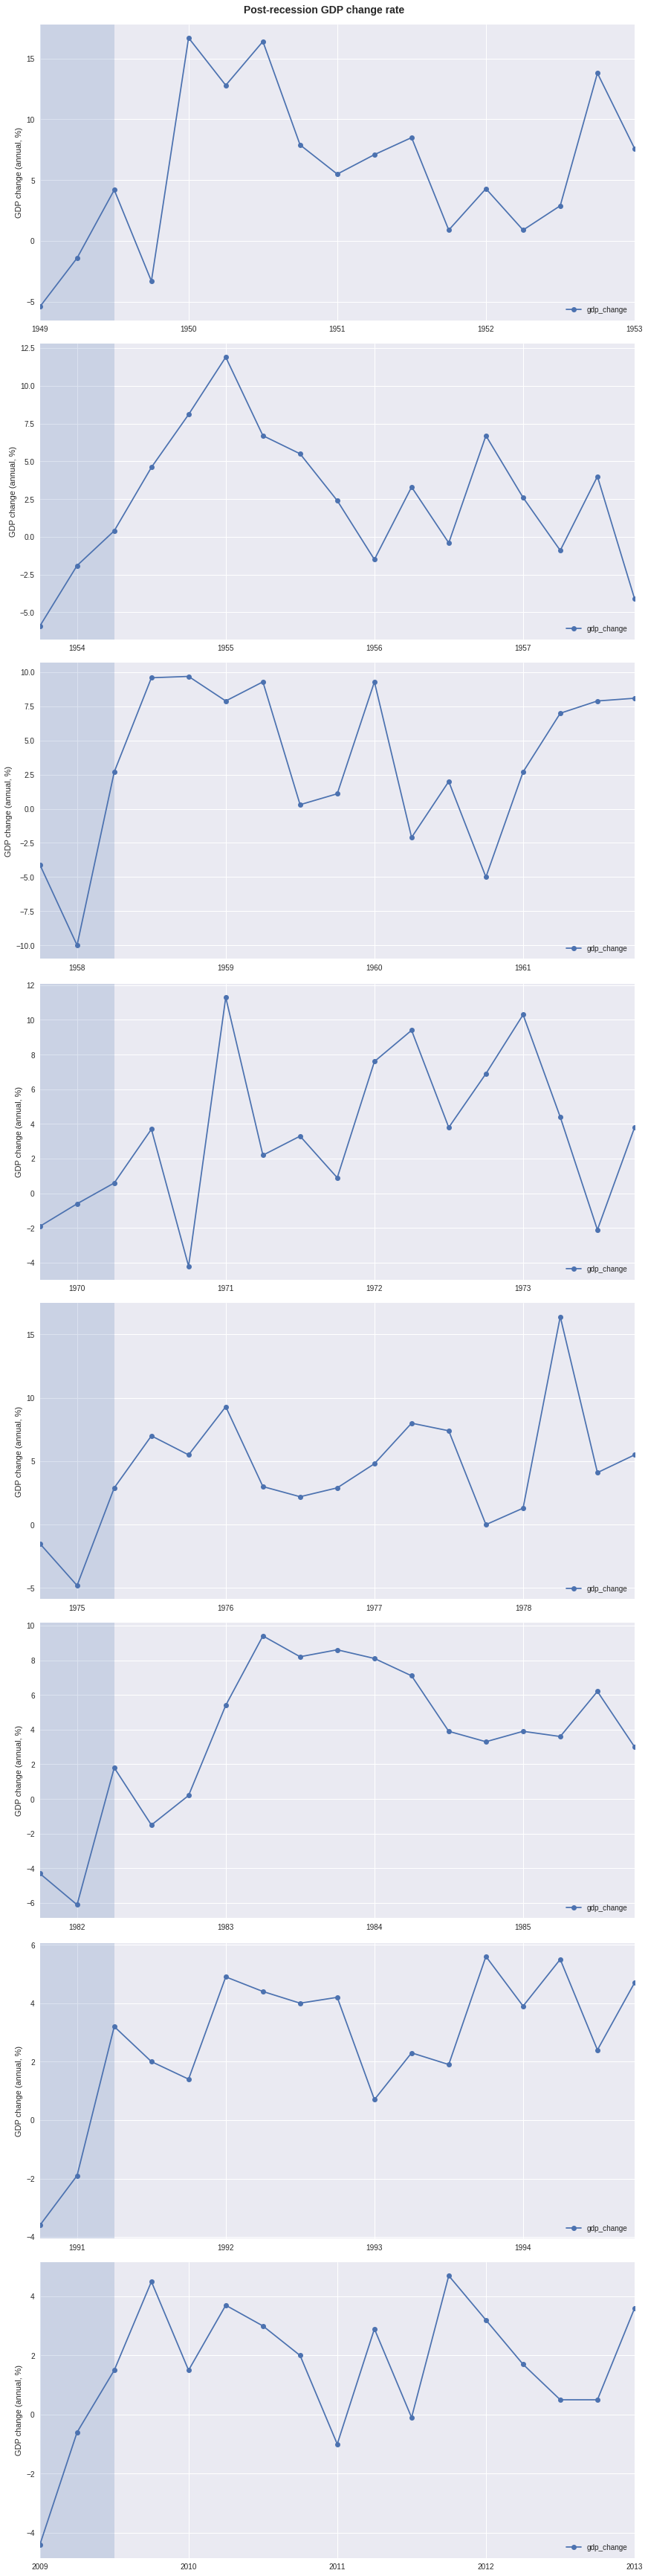

In [164]:
plot_multiple(title='Post-recession GDP change rate', 
              column='gdp_change', 
              ylabel='GDP change (annual, %)')

We can observe that in general, the GDP growth rate is high for 3-4 quarters after the end of a recession, with a dip at quarters 5-6.

<a id=’section_2’></a>

## Unemployment

Now we look at the rate of unemployment after each crisis. The data comes from the [Bureau of Labor Statistics](https://data.bls.gov/timeseries/LNS14000000).

In [165]:
unemp_df = pd.read_excel(PATH + 'SeriesReport-20201016142205_b79b84.xlsx', skiprows=10, header=1)
unemp_df = unemp_df.iloc[:, 1:4]
unemp_df.head()

,Year,Period,Value
0,1948,M01,3.4
1,1948,M02,3.8
2,1948,M03,4.0
3,1948,M04,3.9
4,1948,M05,3.5


In [166]:
unemp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 873 entries, 0 to 872
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    873 non-null    int64  
 1   Period  873 non-null    object 
 2   Value   873 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.6+ KB


In [167]:
# Compute new column 'period' from 'Year' and 'Period'
unemp_df['period'] = unemp_df['Year'].astype('str') + '-' + unemp_df['Period'].str.strip('M')

# Keep only 2 columns
unemp_df = unemp_df[['period', 'Value']]

# Rename 'Value' column to 'unemployment'
mapper = {'Value': 'unemployment'}
unemp_df.rename(columns=mapper, inplace=True)

# Keep the first of every 3 months so we can easily convert to quarters
unemp_df = unemp_df.loc[unemp_df.index % 3 == 0]

# Convert 'period' column to a pandas PeriodIndex type with quaterly frequency
unemp_df['period'] = pd.PeriodIndex(unemp_df['period'], freq='Q')

# Set column 'period' to index
unemp_df = unemp_df.set_index('period')

unemp_df.head()

,unemployment
period,
1948Q1,3.4
1948Q2,3.9
1948Q3,3.6
1948Q4,3.7
1949Q1,4.3


Before we look at each post-recession period, let's visualize the rate of unemployment throughout the whole period in question.

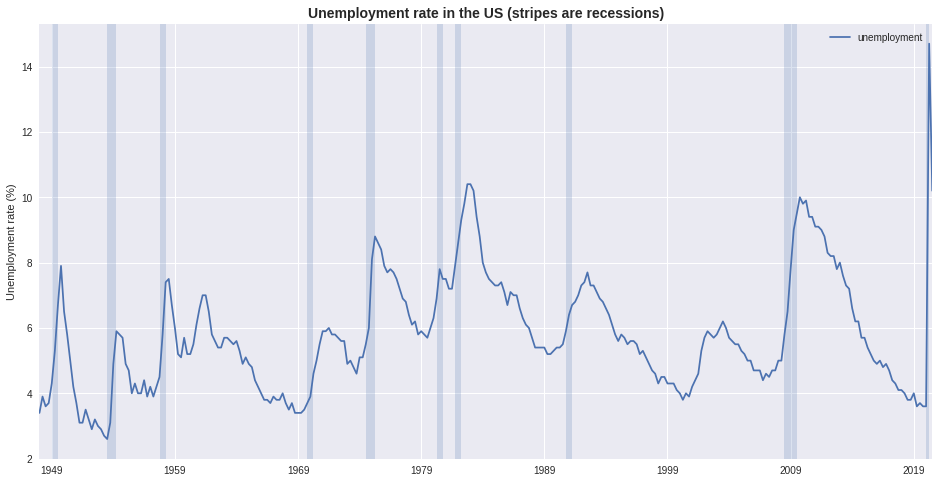

In [168]:
ax = unemp_df.plot(figsize=(16, 8), grid=True)
plt.xlabel('')
plt.ylabel('Unemployment rate (%)')
plt.title('Unemployment rate in the US (stripes are recessions)', fontdict=title_fontdict)
draw_stripes(ax=ax)
plt.show()

We now join this information with our original dataframe.

In [169]:
df = df.join(unemp_df, on='period', how='left')
df.head(8)

,period,gdp_change,unemployment
0,1947Q2,-1.0,NaN
1,1947Q3,-0.8,NaN
2,1947Q4,6.4,NaN
3,1948Q1,6.2,3.4
4,1948Q2,6.8,3.9
5,1948Q3,2.3,3.6
6,1948Q4,0.4,3.7
7,1949Q1,-5.4,4.3


In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype        
---  ------        --------------  -----        
 0   period        293 non-null    period[Q-DEC]
 1   gdp_change    293 non-null    float64      
 2   unemployment  290 non-null    float64      
dtypes: float64(2), period[Q-DEC](1)
memory usage: 7.0 KB


It's time to take a look at the rate of unemployment in the period after each recession.

<IPython.core.display.Javascript object>

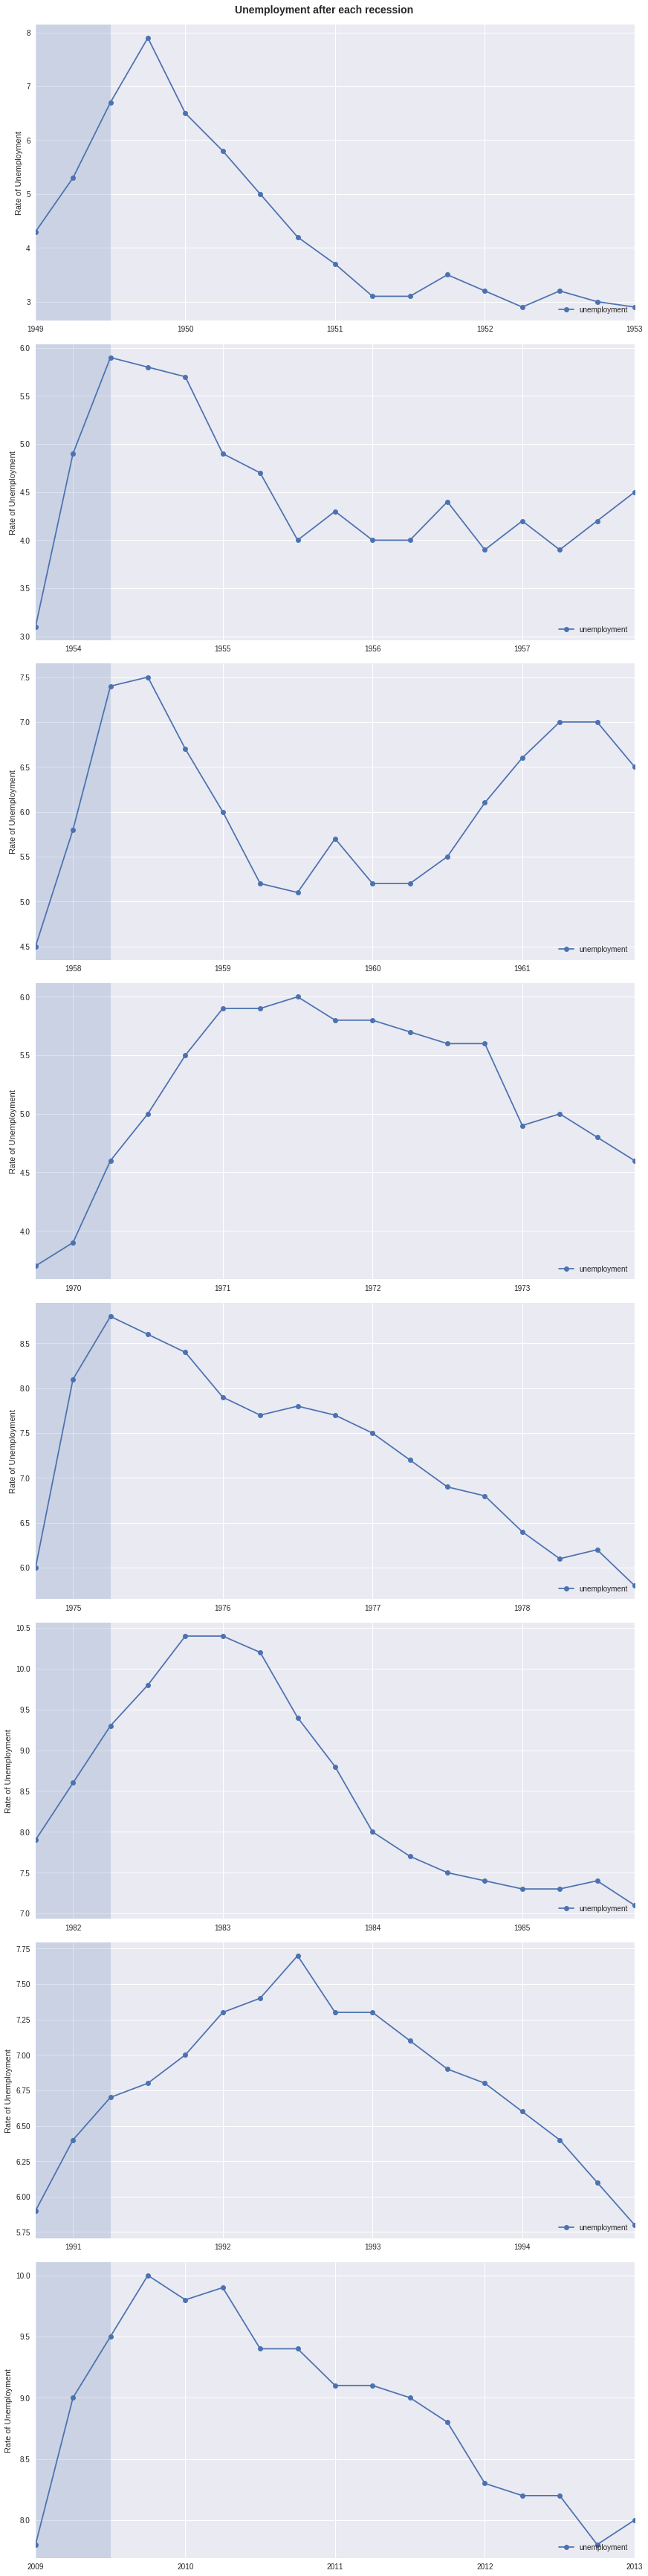

In [171]:
plot_multiple(dataframe=df,
              title='Unemployment after each recession', 
              column='unemployment', 
              ylabel='Rate of Unemployment')

As intuition would tell us, the rate of unemployment decreases during post-recession recoveries. However, this effect is delayed. The peak of unemployment for these 8 recessions occured as follows:  
1949 - unemployment peaked 2 quarters after the recession ended  
1954 - 1 quarter  
1958 - 2 quarters  
1970 - 6 quarters  
1975 - 1 quarter  
1982 - 3-4 quarters  
1991 - 6 quarters  
2009 - 2 quarters  

<a id=’section_3’></a>

## Wealth Inequality

The Gini coefficient (or Gini index) describes the income or wealth inequality within a country. It was developed by the Italian statistician and sociologist Corrado Gini.

A Gini coefficient of 0 expresses full equality and 1 would be maximal inequality (1 person holding all of the wealth or income).

The dataset that we will use comes from the [United States Census Bureau](https://www.census.gov/data/tables/time-series/demo/income-poverty/historical-income-inequality.html).

In [172]:
gini_df = pd.read_excel(PATH + 'tableA4.xlsx', sheet_name='GINI', names=['Year', 'Gini'])

In [173]:
gini_df.tail()

,Year,Gini
50,2009 6,0.468
51,2010 5,0.470
52,2013 3,0.482
53,2013 4,0.476
54,2017 2,0.489


In [174]:
gini_df.dtypes

Year     object
Gini    float64
dtype: object

In [175]:
# Some values in the Year column have a reference number next to them.
gini_df['Year'] = gini_df['Year'].astype('str')
gini_df['Year'] = gini_df['Year'].apply(lambda x: x.split()[0])

In [176]:
# There are two values for the year 2017. The first one corresponded to an 
#   obsolete calculation method.
gini_df.loc[gini_df['Year'] == '2017']

,Year,Gini
30,2017,0.482
54,2017,0.489


In [177]:
gini_df.drop_duplicates(subset='Year', inplace=True)

In [178]:
# Sort dataframe by 'Year'
gini_df = gini_df.sort_values('Year').reset_index(drop=True)

# Compute 'period' column as a PeriodIndex with annual frequency
gini_df['period'] = pd.PeriodIndex(gini_df['Year'], freq='A')

# In order to resample 'period', we first convert it to datetime, 
#   set it as index, resample and convert it back to PeriodIndex (quarterly now)
gini_df['period'] = gini_df['period'].values.astype('datetime64[Y]')
gini_df.set_index('period', inplace=True)
gini_df = gini_df.resample('Q').ffill()
gini_df.index = gini_df.index.to_period('Q')

# Drop 'Year'
gini_df.drop(columns=['Year'], inplace=True)

gini_df.head()

,Gini
period,
1967Q1,0.397
1967Q2,0.397
1967Q3,0.397
1967Q4,0.397
1968Q1,0.386


We can now visualize all of our Gini values. This amounts to a visualization of wealth inequality in the United States over the last 50 years or so.

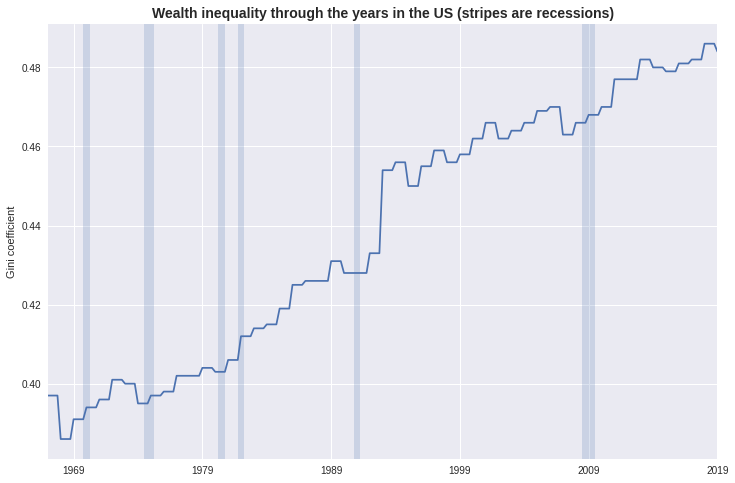

In [179]:
ax = gini_df.plot(grid=True, figsize=(12,8), legend=False)
plt.xlabel('')
plt.ylabel('Gini coefficient')
plt.title('Wealth inequality through the years in the US (stripes are recessions)', fontdict=title_fontdict)
draw_stripes(ax=ax)
plt.show()

Let's join this information to our original dataframe.

In [180]:
df = df.join(gini_df, on='period', how='left')

In [181]:
df.tail(10)

,period,gdp_change,unemployment,Gini
283,2018Q1,3.8,4.1,0.486
284,2018Q2,2.7,4.0,0.486
285,2018Q3,2.1,3.8,0.486
286,2018Q4,1.3,3.8,0.486
287,2019Q1,2.9,4.0,0.484
288,2019Q2,1.5,3.6,NaN
289,2019Q3,2.6,3.7,NaN
290,2019Q4,2.4,3.6,NaN
291,2020Q1,-5.0,3.6,NaN
292,2020Q2,-31.4,14.7,NaN


In [182]:
# Obtain indices from rec_ends where 'Gini' is a number
idx = make_idx_list(rec_ends, 'Gini')
idx

[91, 111, 139, 175, 248]

<IPython.core.display.Javascript object>

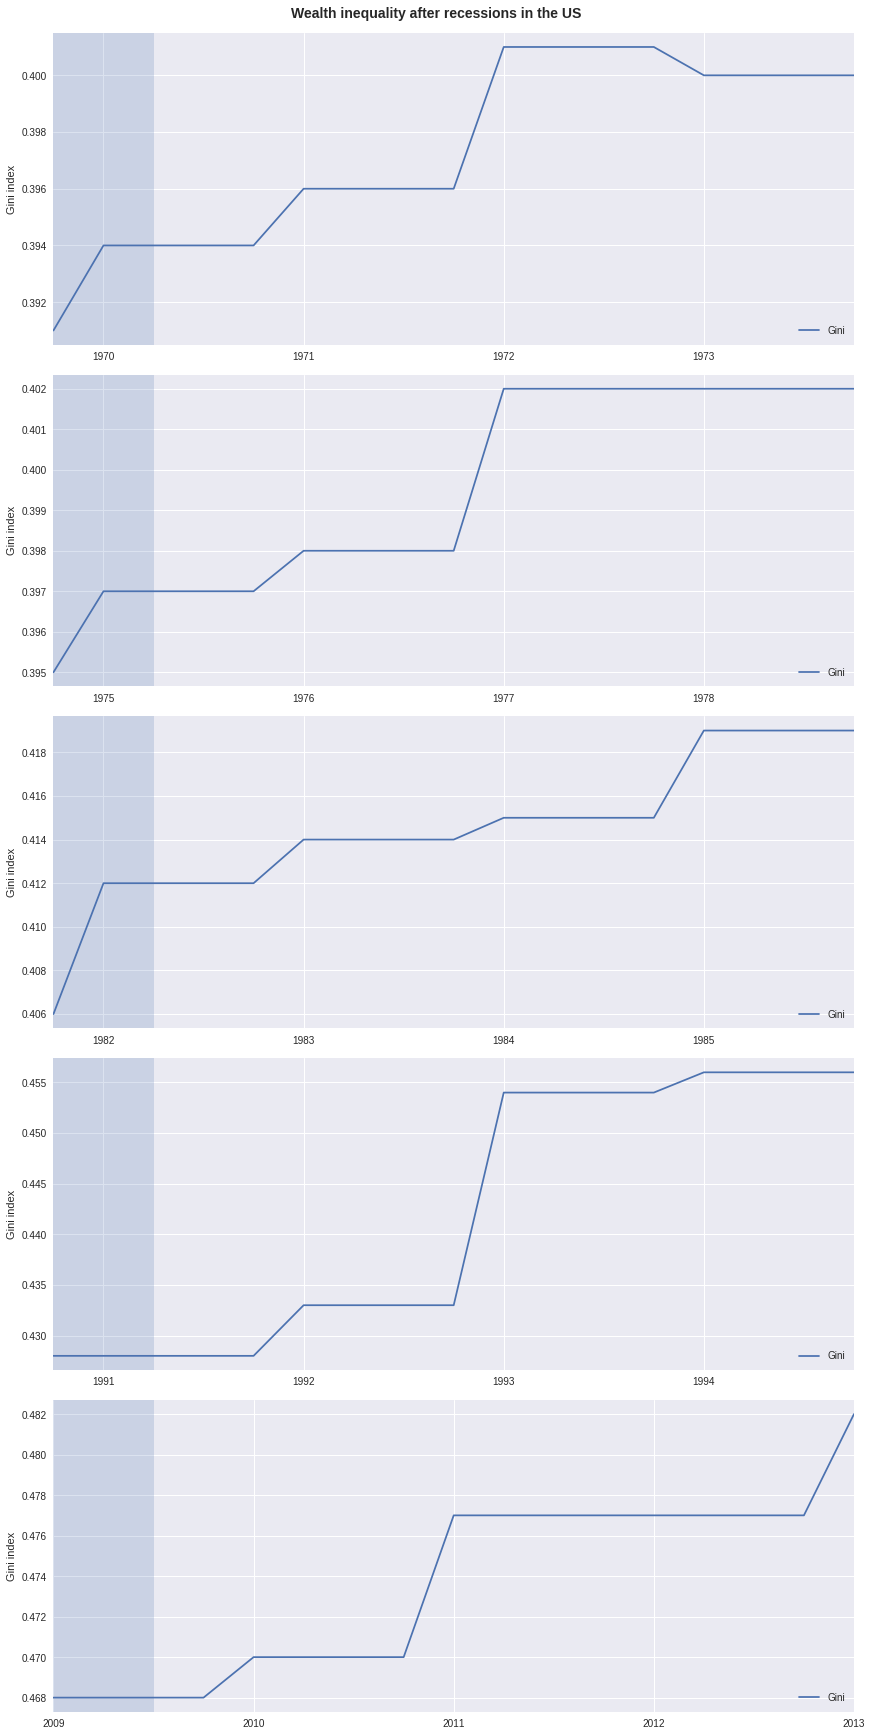

In [183]:
plot_multiple(dataframe=df, idx=idx, title='Wealth inequality after recessions in the US', 
              column='Gini', ylabel='Gini index', num_axes=5, figsize=(12,24), style='-')

Clearly, wealth inequality increased after each recession. However, there's a big caveat: wealth inequality may have increased anyway, whether there was a recession or not.  
For this we look at the previous plot ("Wealth inequality after recessions in the US") and we see that the Gini index has been increasing steadily in the US during periods of growth and contraction.

<a id=’section_4’></a>

## Debt-to-GDP ratio

We end by looking at the Debt to GDP ratio after recessions in the US. This is a measurment of a country's government debt in relation to the total size of the economy.

It's not uncommon for this ratio to increase after disruptive negative events like wars, natural disasters, recessions and others, as the economic activity might slow down or decrease while government accrues more debt to cover budget deficits or stimulate the economy.

We start by looking at data from the [Treasury of the United States](https://fiscaldata.treasury.gov/datasets/historical-debt-outstanding/historical-debt-outstanding). This dataset contains the total outstanding debt amount for each year since 1790!

In [184]:
debt_df = pd.read_csv(PATH + 'HstDebt_all_years 2.csv', parse_dates=[0])
debt_df.head()

,Record Date,Debt Outstanding Amount,Source Line Number,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number
0,1790-01-01,71060508.50,1,1790,2,1790,1,1,1
1,1791-01-01,75463476.52,1,1791,2,1791,1,1,1
2,1792-01-01,77227924.66,1,1792,2,1792,1,1,1
3,1793-01-01,80358634.04,1,1793,2,1793,1,1,1
4,1794-01-01,78427404.77,1,1794,2,1794,1,1,1


In [185]:
debt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Record Date              232 non-null    datetime64[ns]
 1   Debt Outstanding Amount  232 non-null    float64       
 2   Source Line Number       232 non-null    int64         
 3   Fiscal Year              232 non-null    int64         
 4   Fiscal Quarter Number    232 non-null    int64         
 5   Calendar Year            232 non-null    int64         
 6   Calendar Quarter Number  232 non-null    int64         
 7   Calendar Month Number    232 non-null    int64         
 8   Calendar Day Number      232 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 16.4 KB


In [186]:
# Keep and rename the first 2 columns
debt_df = debt_df.iloc[:, 0:2]
mapper = {'Record Date': 'period', 'Debt Outstanding Amount': 'debt'}
debt_df.rename(mapper=mapper, axis=1, inplace=True)
debt_df.set_index('period', inplace=True)

debt_df.tail()

,debt
period,
2016-09-30,1.957344e+13
2017-09-30,2.024490e+13
2018-09-30,2.151606e+13
2019-09-30,2.271940e+13
2020-09-30,2.694539e+13


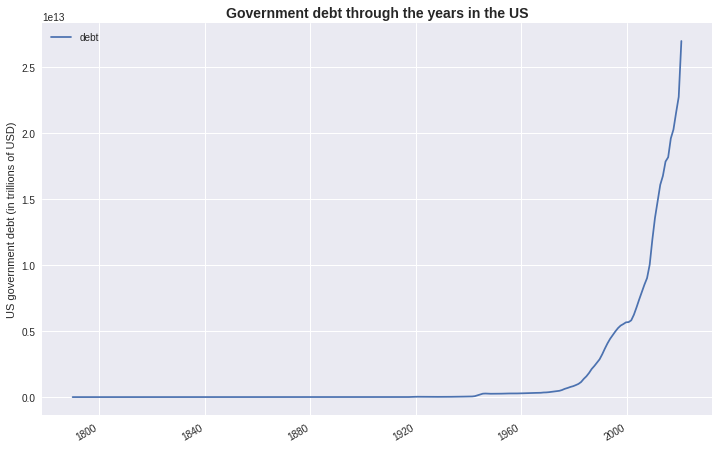

In [187]:
debt_df.plot(grid=True, figsize=(12,8))
plt.xlabel('')
plt.ylabel('US government debt (in trillions of USD)')
plt.title('Government debt through the years in the US', fontdict=title_fontdict)
plt.show()

It's difficult in that graph to see what happened before the middle of the 20th century, as the values are too small relative to recent ones and the expansion of the debt is clearly not linear. It may be better to convert the y-scale to logarithmic.

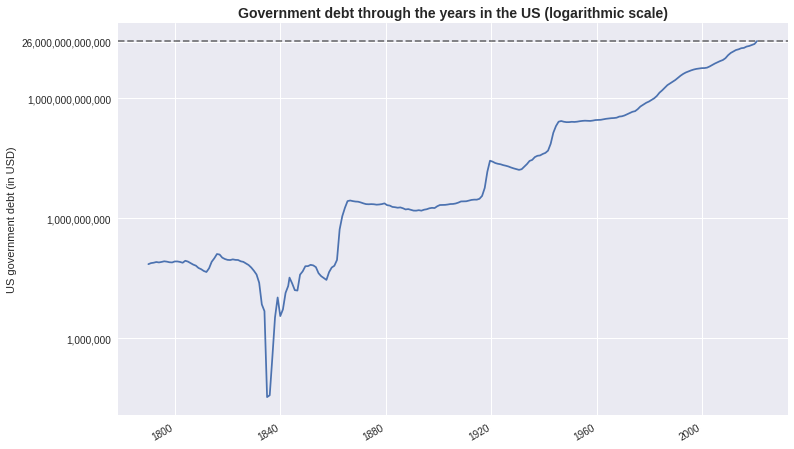

In [188]:
ax = debt_df.plot(grid=True, figsize=(12,8), logy=True, legend=False)
plt.yticks([1000000, 1000000000, 1000000000000, 26000000000000], 
           labels=['1,000,000', '1,000,000,000', '1,000,000,000,000', '26,000,000,000,000'])

ax.axhline(y=int(debt_df.iloc[-1]), ls='--', color='black', alpha=0.5)
plt.xlabel('')
plt.ylabel('US government debt (in USD)')
plt.title('Government debt through the years in the US (logarithmic scale)', fontdict=title_fontdict)
plt.show()

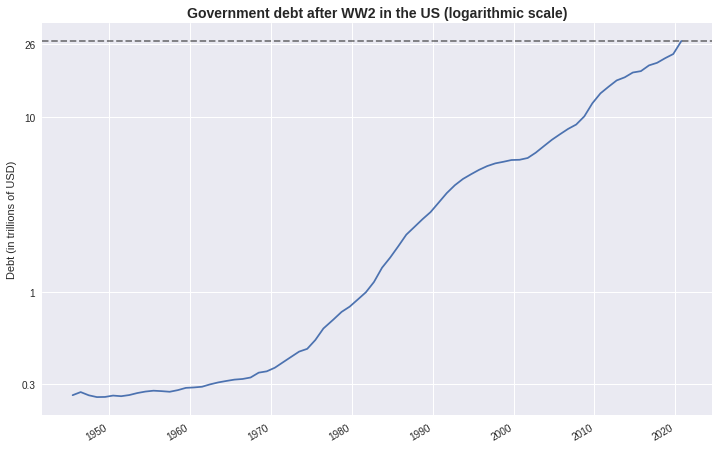

In [189]:
ax = debt_df.loc[debt_df.index > np.datetime64('1945-01-01')].plot(grid=True, figsize=(12,8), logy=True, legend=False)
plt.yticks([300000000000, 1000000000000, 10000000000000, 26000000000000], 
           labels=['0.3', '1', '10', '26'])

ax.axhline(y=int(debt_df.iloc[-1]), ls='--', color='black', alpha=0.5)
plt.xlabel('')
plt.ylabel('Debt (in trillions of USD)')
plt.title('Government debt after WW2 in the US (logarithmic scale)', fontdict=title_fontdict)
plt.show()

As interesting as it is to look at the absolute values for government debt, what we're really after is the debt-to-gdp ratio. There is another dataset that contains this data from 1900 onwards and is provided by the [Congressional Budget Office](https://www.cbo.gov/publication/56516).

In [190]:
debt_ratio_df = pd.read_excel(PATH + '56516-LTBO-Data-Underlying-Figures.xlsx', 
                            sheet_name='Figure 1', usecols=[0, 1], skiprows=7, 
                            names=['period', 'debt2gdp'])
debt_ratio_df.head()

,period,debt2gdp
0,1900,6.6
1,1901,5.7
2,1902,5.4
3,1903,5.0
4,1904,4.7


In [191]:
debt_ratio_df.tail()

,period,debt2gdp
148,2048,183.227
149,2049,189.093
150,2050,195.184
151,NaN,NaN
152,Back to Table of Contents,NaN


In [192]:
# Get rid of last two rows
debt_ratio_df = debt_ratio_df.iloc[:151]

In [193]:
# As before, several steps to end up with 'period' as the index 
#   and with type PeriodIndex (Q)
debt_ratio_df['period'] = debt_ratio_df['period'].astype('float32')
debt_ratio_df['period'] = pd.to_datetime(debt_ratio_df['period'], format='%Y')
debt_ratio_df.set_index('period', inplace=True)
debt_ratio_df = debt_ratio_df.resample('Q').ffill()
debt_ratio_df.index = debt_ratio_df.index.to_period('Q')
debt_ratio_df.head()

,debt2gdp
period,
1900Q1,6.6
1900Q2,6.6
1900Q3,6.6
1900Q4,6.6
1901Q1,5.7


Let's visualize the change in Debt-to-GDP ratio over time. The dashed line is the present time and the shaded area represents projected values.

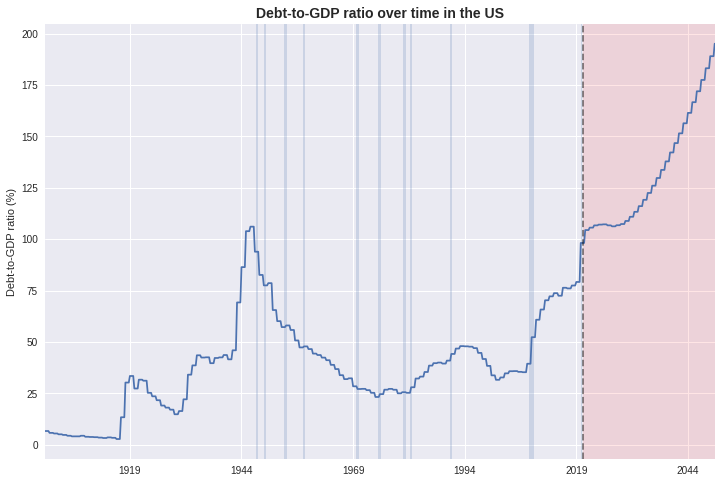

In [194]:
ax = debt_ratio_df.plot(grid=True, figsize=(12,8), legend=False)

ax.axvline(x='2020Q3', ls='--', color='black', alpha=0.5)
ax.axvspan(xmin='2020Q3', xmax=debt_ratio_df.index.max(), 
           alpha=0.1, facecolor='red')

draw_stripes(ax=ax)

plt.xlabel('')
plt.ylabel('Debt-to-GDP ratio (%)')
plt.title('Debt-to-GDP ratio over time in the US', fontdict=title_fontdict)
plt.show()

We now join the Debt-to-GDP information with the original dataframe df.

In [196]:
df = df.join(debt_ratio_df, on='period', how='left')
df.head()

,period,gdp_change,unemployment,Gini,debt2gdp
0,1947Q2,-1.0,NaN,NaN,93.9
1,1947Q3,-0.8,NaN,NaN,93.9
2,1947Q4,6.4,NaN,NaN,93.9
3,1948Q1,6.2,3.4,NaN,82.6
4,1948Q2,6.8,3.9,NaN,82.6


<IPython.core.display.Javascript object>

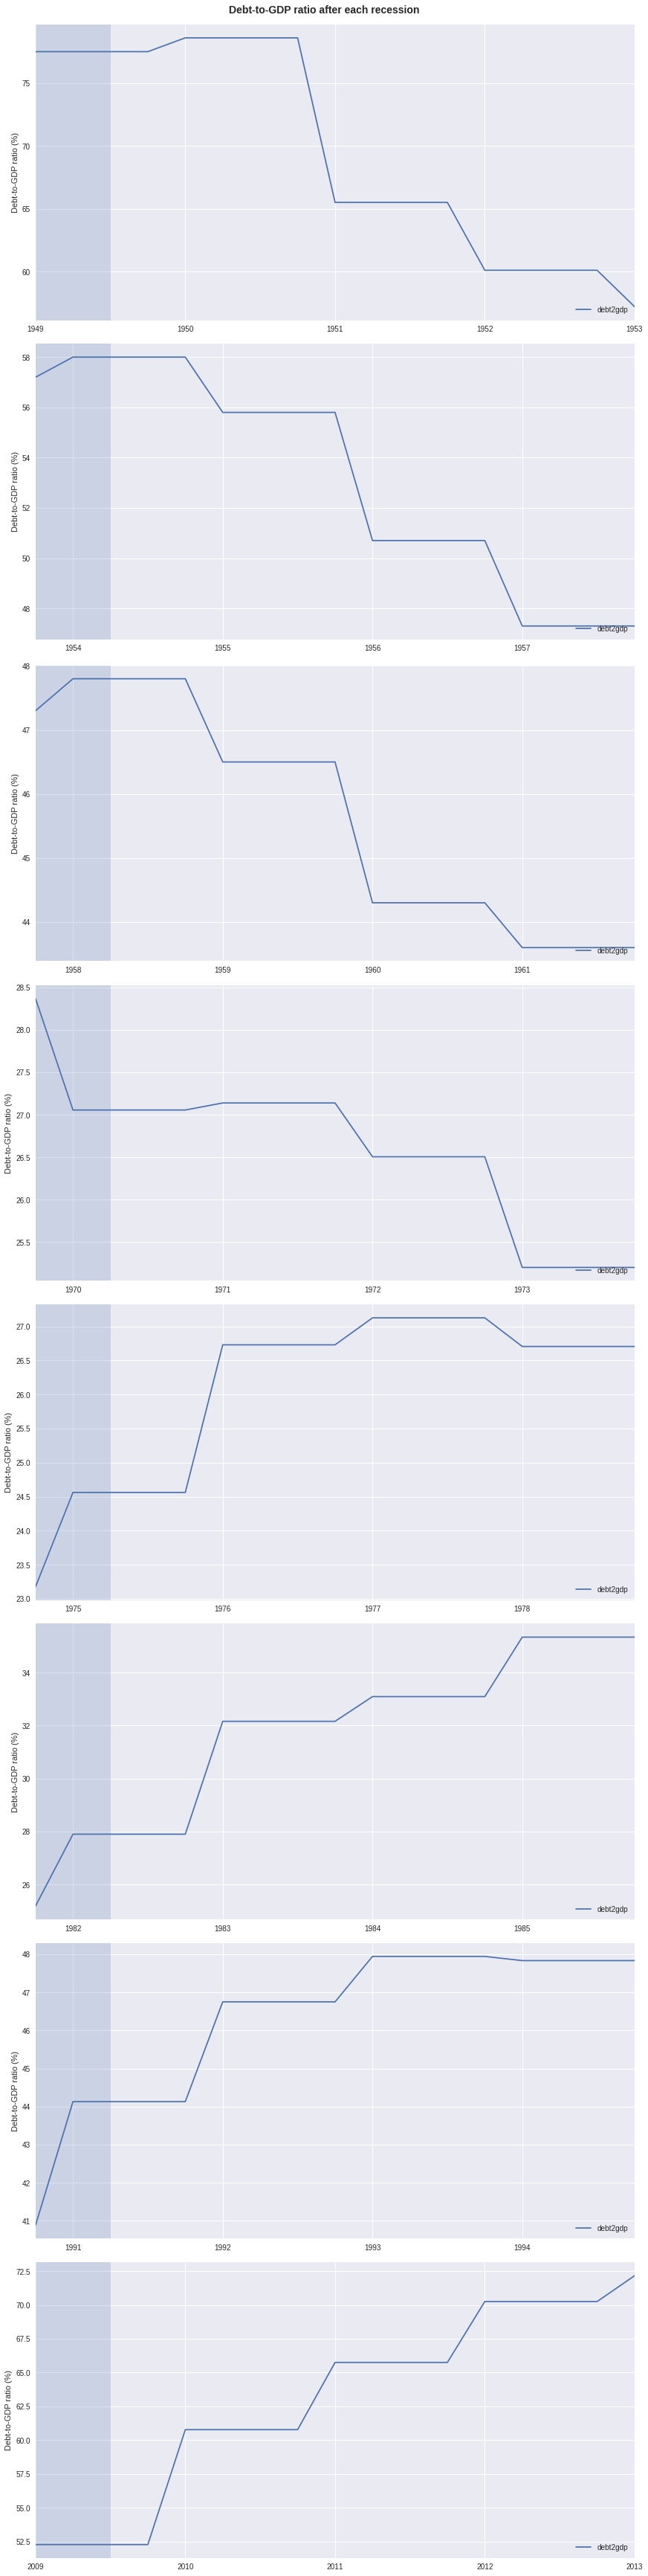

In [197]:
plot_multiple(dataframe=df, 
              title='Debt-to-GDP ratio after each recession', 
              column='debt2gdp', 
              ylabel='Debt-to-GDP ratio (%)', style='-')

One can see that there is no definite trend here. The first 4 recoveries saw a decrease in Debt-to-GDP ratio, while the latest 4 saw an increase.  
This may be explained by the fact that GDP growth after the first 4 recessions was very strong, with peaks over 10%. The most recents post-recessions recoveries where tamer, with peaks under 10% (and under 5% for the last two recessions).  
Also, as we visualized with the first Debt dataset, the government debt in the US grew slowly before 1970 and grew exponentially after.

<a id=’section_5’></a>

## All Indicators

Finally, let's visualize all indicators for each post-recession recovery. Because the indicators are on such different scales, we will normalize the values. The graphs won't be informative of particular numbers, but we can better visualize tendencies in different columns all at once.

In [198]:
# We'll normalize the values using sklearn.preprocessing.MinMaxScaler, 
#   which will give every column a range of 0 to 1.

from sklearn import preprocessing

x = df.iloc[:, 1:].values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_scaled = pd.DataFrame(x_scaled)
mapper={0: 'GDP change (%)', 1: 'Unemployment', 
        2: 'Gini index', 3: 'Debt-to-GDP ratio'}
df_scaled.rename(mapper=mapper, axis='columns', inplace=True)

In [199]:
df_scaled.describe()

,GDP change (%),Unemployment,Gini index,Debt-to-GDP ratio
count,293.000000,290.000000,209.000000,293.000000
mean,0.716461,0.261157,0.524306,0.301433
std,0.090405,0.142690,0.319345,0.236343
min,0.000000,0.000000,0.000000,0.000000
25%,0.677755,0.157025,0.180000,0.126717
50%,0.715177,0.247934,0.640000,0.236111
75%,0.758836,0.347107,0.800000,0.435041
max,1.000000,1.000000,1.000000,1.000000


In [200]:
df_scaled = pd.concat([df['period'], df_scaled], axis=1)

<IPython.core.display.Javascript object>

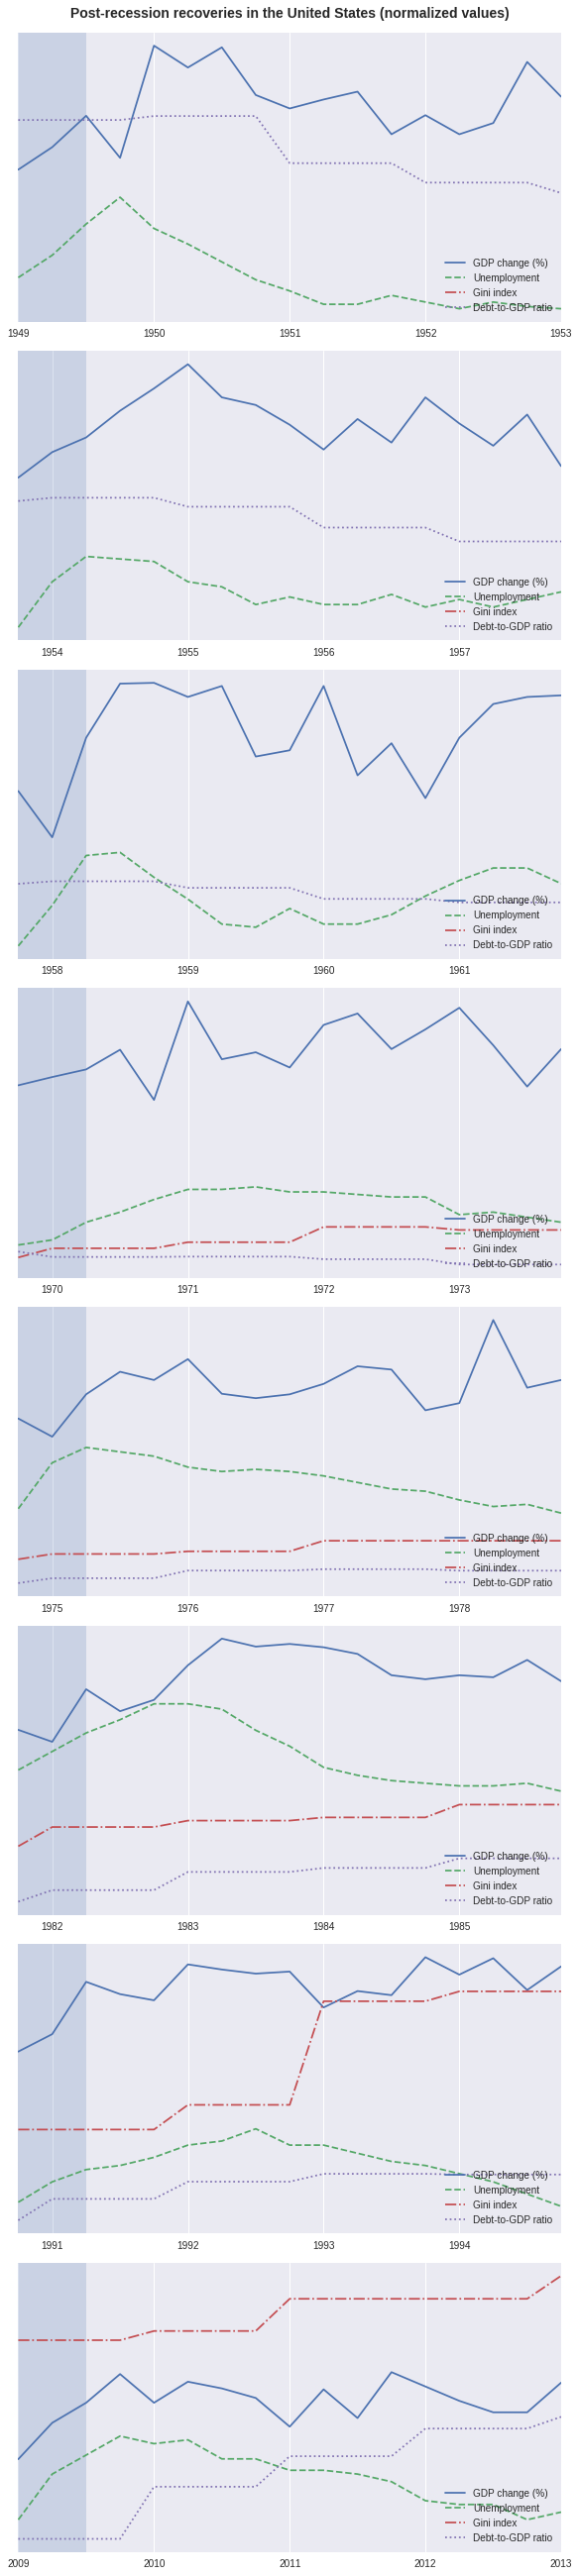

In [217]:
plot_multiple(title="""Post-recession recoveries in the United States (normalized values)""", 
              column=['GDP change (%)',	'Unemployment',	'Gini index',	'Debt-to-GDP ratio'], 
              ylabel='',
              dataframe=df_scaled, 
              idx=rec_ends, 
              num_axes=8, 
              figsize=(8,36), 
              style=['-', '--', '-.', ':'],
              yticks=False,
              legend=[True])
plt.show()